In [1]:
import operator, random, requests
import time, csv, os
import pandas as pd
import numpy as np
from ast import literal_eval
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

# Colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

In [2]:
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the CMU data

In [3]:
DATA_PATH = './raw_data'
CHAR_PATH = os.path.join(DATA_PATH, 'character.metadata.tsv')
ETHNICITIES_PATH = os.path.join(DATA_PATH, 'ethnicities.csv')
MOVIE_PATH = os.path.join(DATA_PATH, 'movie.metadata.tsv')
THE_NUMBERS_PATH = os.path.join(DATA_PATH, 'actors_xxxx_the_numbers')

## 1.1 Characters dataset

In [4]:
a_cols = ['wikipedia_m_ID', 'freebase_m_ID', 'm_release_date', 'character_name', 'actor_dob', 'actor_gender',
          'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 'freebase_character_map',
          'freebase_character_id', 'freebase_actor_id']
df_chars = pd.read_csv(CHAR_PATH, sep='\t', names=a_cols)

## 1.2 Movie dataset

In [5]:
m_cols = ["wikipedia_m_ID", "freebase_m_ID", "m_name", "m_release_date", "m_BO_revenue", "m_runtime", "m_languages",
          "m_countries", "m_genres"]
df_movies = pd.read_csv(MOVIE_PATH, sep='\t', names=m_cols,
                        converters={'m_languages': literal_eval, 'm_countries': literal_eval, 'm_genres': literal_eval})

# 2 Quick look at the CMU data

## 2.1 Characters dataset

In [6]:
df_chars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   wikipedia_m_ID          450669 non-null  int64  
 1   freebase_m_ID           450669 non-null  object 
 2   m_release_date          440674 non-null  object 
 3   character_name          192794 non-null  object 
 4   actor_dob               344524 non-null  object 
 5   actor_gender            405060 non-null  object 
 6   actor_height            154824 non-null  float64
 7   actor_ethnicity         106058 non-null  object 
 8   actor_name              449441 non-null  object 
 9   actor_age               292556 non-null  float64
 10  freebase_character_map  450669 non-null  object 
 11  freebase_character_id   192804 non-null  object 
 12  freebase_actor_id       449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


In [7]:
df_chars.sample(4)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
96136,19953974,/m/04yg7qt,1961-10-13,NaN,1938-01-04,M,NaN,NaN,Scilla Gabel,23.0,/m/09j1vhz,NaN,/m/04lgw3q
286052,933321,/m/03r8x1,1970-06-23,Pvt. Little Joe,1940-01-31,M,1.77,NaN,Stuart Margolin,30.0,/m/0h614_n,/m/0h614_r,/m/083wp6
386429,1607895,/m/05g8pg,2004-12-23,NaN,1948,M,NaN,/m/03bx0k4,Leung Siu-Lung,56.0,/m/03l615s,NaN,/m/0h3gq7
312425,5283093,/m/0dcgs9,1986-06-05,NaN,1958-12-27,F,1.63,NaN,Barbara Crampton,27.0,/m/0jyj7j,NaN,/m/0bftyj


## 2.2 Movie dataset

In [8]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikipedia_m_ID  81741 non-null  int64  
 1   freebase_m_ID   81741 non-null  object 
 2   m_name          81741 non-null  object 
 3   m_release_date  74839 non-null  object 
 4   m_BO_revenue    8401 non-null   float64
 5   m_runtime       61291 non-null  float64
 6   m_languages     81741 non-null  object 
 7   m_countries     81741 non-null  object 
 8   m_genres        81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [9]:
df_movies.sample(4)

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
682,25736891,/m/09v4kv1,Wrestling,2008,NaN,93.0,{},{'/m/09c7w0': 'United States of America'},"{'/m/02l7c8': 'Romance Film', '/m/07s9rl0': 'D..."
40769,31322444,/m/0gjcrwr,Semmelweis - Retter der Mütter,1950,NaN,NaN,{'/m/04306rv': 'German Language'},{'/m/03f2w': 'German Democratic Republic'},{'/m/07s9rl0': 'Drama'}
5987,21729694,/m/05mvzv2,The Cage,1963,NaN,85.0,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},{'/m/01g6gs': 'Black-and-white'}
22923,17216568,/m/043qnz6,Peasants,1978-03-25,NaN,125.0,{'/m/02hwhyv': 'Korean Language'},{'/m/06qd3': 'South Korea'},{'/m/07s9rl0': 'Drama'}


# 3. CMU data preprocessing
## 3.1 Characters dataset
#### Columns conversion

In [10]:
# Change problematic dates
# Min value of date '1010-12-02' qui plus petit que la plus petite date de to_datetime
df_chars['m_release_date'] = pd.to_datetime(df_chars['m_release_date'], errors='coerce')
df_chars['actor_dob'] = df_chars['actor_dob'].apply(lambda x: str(x) if len(str(x)) <= 10 else str(x)[:10])
df_chars['actor_dob'] = pd.to_datetime(df_chars['actor_dob'], errors='coerce')

#### Ethnicities

In [11]:
dict_ethnicities = {}
def map_ethnicities(arr_ethn):
    """
    Queries the FreeBase dump to get ethnicities as dict instead of Freebase ID.
    :param arr_ethn: array of ethnicities
    :return:
    """
    for x in arr_ethn[1:]:
        time.sleep(1)
        x = x.split('/')[2]
        query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22%2Fm%2F{}%22.%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(x)
        response_json = requests.get(query).json()['results']['bindings']
        if len(response_json):
            value = response_json[0]['sLabel']['value']
            dict_ethnicities.update({'/m/'+x: value})

def save_ethnicities():
    """
    Saves ethnicities list in a file from the dict created in map_ethnicities.

    :return:
    """
    with open(ETHNICITIES_PATH, 'w', encoding="utf-8") as f:
        writer_object = csv.writer(f)
        for key in dict_ethnicities.keys():
            value = dict_ethnicities[key]
            writer_object.writerow([key, value])
    return

def get_ethnicities():
    """
    Creates a dict for ethnicities, as strings to be able to read them.

    :return: dict, ideal to give to a DataFrame
    """
    ethnicities = {}
    with open(ETHNICITIES_PATH, 'r', encoding="utf-8") as f:
        reader_object = csv.reader(f)
        for data in reader_object:
            if data:
                key, value = data
                ethnicities.update({key:value})
    return ethnicities

In [12]:
# Those lines were run only once in order to create the 'ethnicities.csv' file. They query the wikidata database to get the name of the ethnicities.

# map_ethnicities(df_chars['actor_ethnicity'].dropna().unique())
# save_ethnicities()

In [13]:
ethnicities = get_ethnicities()

In [14]:
df_chars['actor_ethnicity'] = df_chars['actor_ethnicity'].apply(lambda x: ethnicities[x] if x in ethnicities.keys() else np.nan)

#### Actors age

In [15]:
# Number of characters whose actor has a negative age when appearing in the movie
nb_chars_negative_age = df_chars[df_chars['actor_age'] <= 0]['actor_age'].value_counts().sum()
print("There are {} characters whose actor has a negative age.".format(nb_chars_negative_age))

There are 433 characters whose actor has a negative age.


#### Actor name

In [16]:
# Number of characters whose actor is named 'NaN'
df_chars['actor_name'].value_counts(dropna=False)[:10]

NaN                   1228
Mel Blanc              791
Mithun Chakraborty     328
Oliver Hardy           299
Mohanlal               234
Moe Howard             225
Mammootty              225
Dharmendra Deol        219
Larry Fine             219
Amitabh Bachchan       206
Name: actor_name, dtype: int64

In [17]:
# Number of characters whose actor is named 'NaN'
nb_chars_nan = df_chars['actor_name'].value_counts(dropna=False)[np.nan]
print("There are {} characters whose actor name is nan.".format(nb_chars_nan))

There are 1228 characters whose actor name is nan.


#### Duplicated characters

In [18]:
# Number of duplicates
nb_char_duplicates = df_chars.duplicated().sum()
print("There are {} duplicated characters. So there is no duplicated row.".format(nb_char_duplicates))

There are 0 duplicated characters. So there is no duplicated row.


In [19]:
# Number of occurrences with same subset of columns as described below
nb_char_duplicates_sub = df_chars.duplicated(
    subset=['wikipedia_m_ID', 'character_name', 'actor_name', 'm_release_date']).sum()
print("There are {} characters which appear in the same movie with the same release date, have the same name and which are played by the same actor."
      .format(nb_char_duplicates_sub)
      )

There are 1086 characters which appear in the same movie with the same release date, have the same name and which are played by the same actor.


#### Casting date of birth

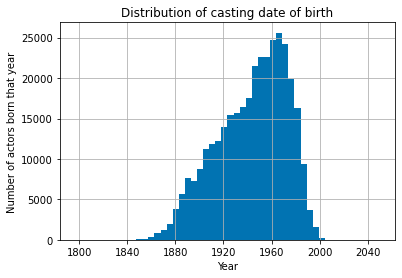

There are 59 actors born before 1850.
There are 1 actors born after 2013.


In [20]:
# Looking at date of birth
plt.title('Distribution of casting date of birth')
plt.xlabel('Year')
plt.ylabel('Number of actors born that year')
plt.hist(df_chars['actor_dob'], bins=50, color=BLUE)
plt.grid()
plt.show()
date_born_min = df_chars.loc[df_chars['actor_dob'].dt.year < 1850]['wikipedia_m_ID'].count()
date_born_max = df_chars.loc[df_chars['actor_dob'].dt.year > 2013]['wikipedia_m_ID'].count()
print("There are {} actors born before 1850.\n"
      "There are {} actors born after 2013.".format(date_born_min, date_born_max))

In [21]:
# The actors born before 1850 have all nan as age.
df_chars.loc[df_chars['actor_dob'].dt.year < 1850]['actor_age'].unique()

array([nan])

In [22]:
# The actor born after 2013 has a negative age. He'll be dropped in the next cell
df_chars.loc[df_chars['actor_dob'].dt.year > 2013]['actor_age'].unique()

array([-37.])

In [23]:
date_movie_first_release = df_chars['m_release_date'].min()
print("The first movie is released in {}.".format(date_movie_first_release.year))

The first movie is released in 1888.


The actor database contains following errors:
- **Actors with negative age**: is (at least in some cases (wikipedia_movie_id: 15007384)) due to actors having the same last name, which probably led to some scraping missmatch, e.g. a movie attributed to a son when it was in fact his father acting. We are going to drop those since it is clearly mistaken.
- **Actors with name 'Nan'**: there is no way for us to qualitatively use this data, so we will drop them.
- **Actors duplicates**: some duplicates were identified, we will safely remove them.
- **Actors with old date of birth**: there are some actors with really old date of birth (59 before 1850). It was decided to safely remove their characters.

#### Cleaning

In [24]:
def cast_age(x):
    """
    Casts input to an int, replaces by NaN if casting is not possible.

    :param x: value to cast to int
    :return: value as an int, or as a NaN
    """

    try:
        value = int(x)
    except:
        value = np.nan
    return value

In [25]:
df_chars['actor_age'] = df_chars['actor_age'].apply(lambda x: cast_age(x))
df_chars['actor_age'] = df_chars.apply(lambda row: row['m_release_date'].year - row['actor_dob'].year if (
        row['actor_age'] == np.nan and row['actor_dob'] != np.nan and row['m_release_date'] != np.nan) else row[
    'actor_age'], axis=1)
df_chars = df_chars.loc[(df_chars['actor_age'] >= 0) | (df_chars['actor_age'].isna())]

df_chars = df_chars.loc[(df_chars['actor_dob'].dt.year >= 1850) | (df_chars['actor_dob'].isna())]
df_chars.dropna(subset='actor_name', inplace=True)
df_chars.drop_duplicates(subset=["wikipedia_m_ID", "character_name", "actor_name", "m_release_date"], keep=False,
                         inplace=True)

## 3.2 Movie dataset

#### Columns conversion

In [26]:
# Movie release dates are parsed as datetime.
df_movies['m_release_date'] = pd.to_datetime(df_movies['m_release_date'], errors='coerce')

#### Movie freebase ID

In [27]:
# A sample of movies is taken to get their freebase ID. The average is then done on how much of them had a valid movie freebase ID.
tot = []
k_size = 8
n = 100
for k in range(k_size):
    rd_elements = random.sample(df_movies['freebase_m_ID'].apply(lambda x: x.split('/')[2]).to_list(), n)
    url = '%28%3'
    for x in rd_elements:
        url += 'Ftitle%20%3D%20%22%2Fm%2F' + x + '%22%20%7C%7C%20%3'
    query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3Ftitle%20WHERE%20%7B%20%0A%20%20VALUES%20%3Fmovietype%20%7B%20wd%3AQ11424%7D%0A%20%20%3Fs%20p%3AP31%2Fps%3AP31%20%3Fmovietype.%0A%20%20%3Fs%20wdt%3AP646%20%3Ftitle.%0A%20%20FILTER{}%22%29%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(
        url[:-17])
    response = requests.get(query)
    response = response.json()['results']['bindings']
    tot.append(len(response))

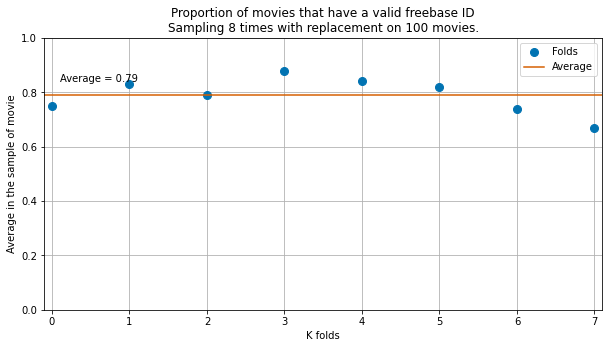

There is around 79.00% of the movies that have an active wikipedia freebase ID.


In [28]:
ratio = [x / n for x in tot]
avg_ratio = sum(ratio) / k_size
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, k_size - 1, k_size).astype(int), ratio, marker='o', linewidth=0, markersize=8, color=BLUE,
         label='Folds')
plt.xticks(np.linspace(0, k_size - 1, k_size).astype(int))
plt.plot(np.linspace(-1, k_size, k_size).astype(int), [avg_ratio] * k_size, color=RED, label='Average')
plt.xlim(- 0.1, k_size - 1 + 0.1)
plt.ylim(0, 1)
plt.xlabel("K folds")
plt.ylabel("Average in the sample of movie")
plt.grid()
plt.text(0.1, avg_ratio + 0.05, "Average = {:.2f}".format(avg_ratio))
plt.legend()
plt.title("Proportion of movies that have a valid freebase ID\nSampling {} times with replacement on {} movies."
          .format(k_size, n))
plt.show()
print("There is around {:.2f}% of the movies that have an active wikipedia freebase ID.".format(avg_ratio * 100))

#### Critical values

In [29]:
# Number of movies with critical values.
nb_critical_values = df_movies[~df_movies.astype(bool).all(axis=1)].shape[0]
print("There are {} rows with critical values. These are values such as: empty dictionaries, 0, nan, etc."
      .format(nb_critical_values))

There are 17949 rows with critical values. These are values such as: empty dictionaries, 0, nan, etc.


#### Duplicated rows

In [30]:
df_temp = df_movies.copy()
df_temp['m_languages'] = df_temp['m_languages'].apply(lambda x: str(list(x.values())))
df_temp['m_countries'] = df_temp['m_countries'].apply(lambda x: str(list(x.values())))
df_temp['m_genres'] = df_temp['m_genres'].apply(lambda x: str(list(x.values())))
nb_movie_duplicated_rows = df_temp.duplicated().sum()
print("There are {} duplicated rows in the movie dataset.".format(nb_movie_duplicated_rows))

There are 0 duplicated rows in the movie dataset.


#### Duplicated movies

In [31]:
df_movies[df_movies.duplicated(subset=['m_name', 'm_release_date'], keep=False)].sort_values('m_name').head(4)

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
64872,24604084,/m/080cdj1,A,1998-01-01,NaN,136.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{'/m/0gw5n2f': 'Japanese Movies', '/m/03q4nz':..."
66267,23488527,/m/06w8mcl,A,1998-01-01,NaN,NaN,{'/m/09bnf': 'Kannada Language'},{'/m/03rk0': 'India'},{'/m/02l7c8': 'Romance Film'}
38544,33545449,/m/0hgrdzf,A Sister to Assist 'Er,NaT,NaN,59.0,{},{},{'/m/05p553': 'Comedy film'}
74307,33545395,/m/0hgrll0,A Sister to Assist 'Er,NaT,NaN,64.0,{},{},{'/m/05p553': 'Comedy film'}


In [32]:
# Number of duplicated movies.
nb_movies_duplicated = df_movies[df_movies.duplicated(subset=['m_name', 'm_release_date'], keep=False)]['wikipedia_m_ID'].count()
print("There are {} duplicated movies.".format(nb_movies_duplicated))

There are 196 duplicated movies.


#### Movie release date

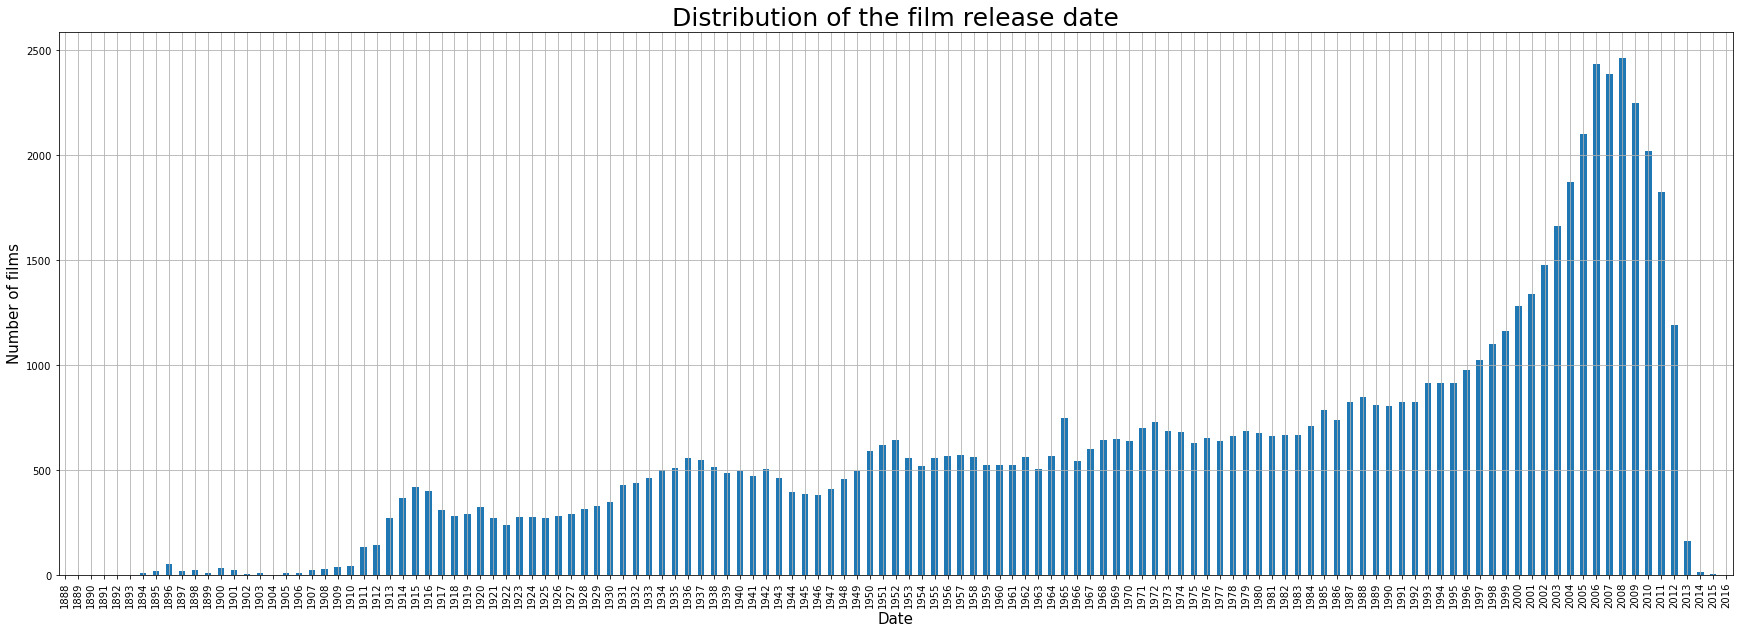

In [33]:
# Movie release date quick overview
df_movies['m_release_date'].dropna().dt.year.sort_values().value_counts(sort=False).plot(kind='bar', figsize=(30, 10))
plt.grid()
plt.title('Distribution of the film release date', fontsize=25)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of films', fontsize=15)
plt.show()

In [34]:
# Quick look at the movies after 2013.
df_movies[df_movies['m_release_date'].dt.year > 2013].sort_values('m_release_date', ascending=False).head()

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
34022,23124260,/m/064mmw7,Jeepers Creepers 4,2016-06-08,NaN,NaN,{},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/03npn': 'Horror'}"
30275,27554912,/m/0c03gcc,Kung Fu Panda 3,2016-03-18,NaN,NaN,{},{},{}
64862,3139382,/m/08tyfg,Battle Angel,2016-01-01,NaN,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
51429,25813358,/m/0gmbk1g,Avatar 2,2015-01-01,NaN,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06n90': 'Science Fiction', '/m/02kdv5l': ..."
53855,32416903,/m/0gys9tc,Total Dhamaal,2015-01-01,NaN,138.0,{'/m/03k50': 'Hindi Language'},{},{'/m/05p553': 'Comedy film'}


In [35]:
nb_movies_after_2013 = df_movies[df_movies['m_release_date'].dt.year > 2013].shape[0]
print(
    "There are {} movies released after 2013. It can be seen that several movies have a wrong date of release (e.g Avatar 2)."
    .format(nb_movies_after_2013)
)

There are 24 movies released after 2013. It can be seen that several movies have a wrong date of release (e.g Avatar 2).


#### Movie runtime

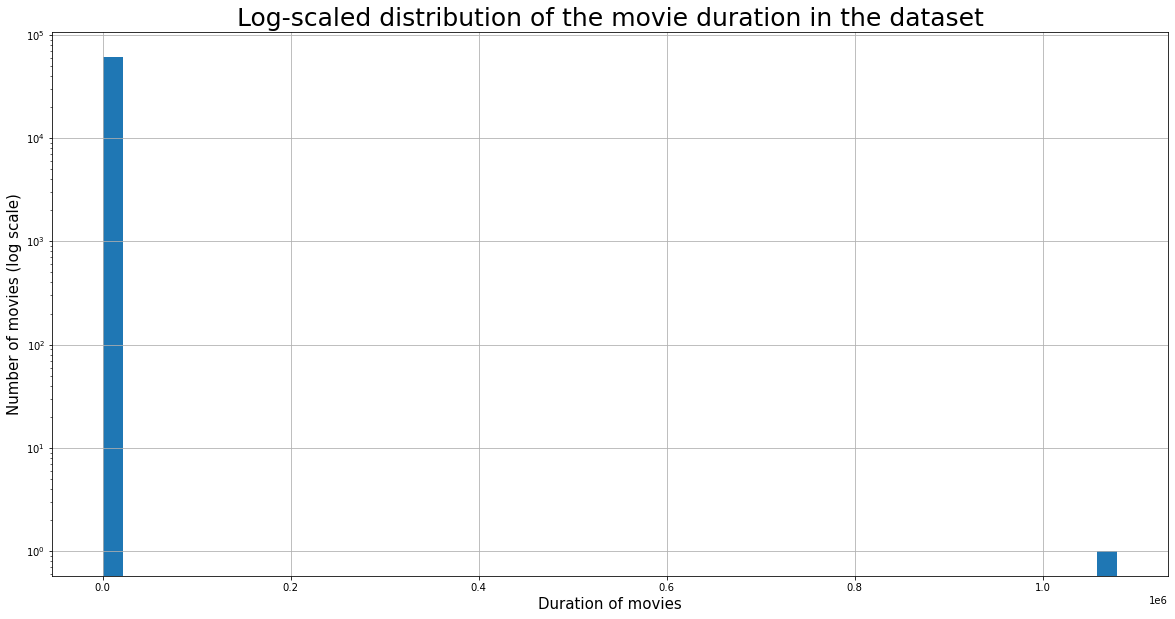

In [36]:
plt.figure(figsize=(20, 10))
df_movies.m_runtime.hist(bins=50)
plt.yscale('log')
plt.ylabel('Number of movies (log scale)', fontsize=15)
plt.xlabel('Duration of movies', fontsize=15)
plt.title("Log-scaled distribution of the movie duration in the dataset", fontsize=25)
plt.show()

In [37]:
nb_movies_duration_inf_1 = df_movies[(df_movies['m_runtime'] >= 1500)]['wikipedia_m_ID'].count()
nb_movies_duration_supp_1500 = df_movies[(df_movies['m_runtime'] <= 1)]['wikipedia_m_ID'].count()
print("There are {} movies which a runtime > 1500 and {} movies with a runtime < 1."
      .format(nb_movies_duration_inf_1, nb_movies_duration_supp_1500))

There are 14 movies which a runtime > 1500 and 107 movies with a runtime < 1.


One can see that there are some outliers in the runtime. It might be due to the time conversion. As the runtime input is supposed to be in minutes, freebase ID will be queried using wikidata to know whether the runtime is the correct one.

The movie database contains following errors:
- **Critical values**: There are values such as empty dictionaries, 0, False in the rows. For practicity, they'll be all replaced by np.nan values.
- **Duplicated movies**: There are movies that can be considered identical (same movie name and same release date). Some of them are duplicated. They'll be safely removed by keeping the first one as they represent the same movie.
- **Movie release date**: There are some outliers in the movie release date. This mainly concerns movies after 2013. It is due to the creation date of the dataset: 2013. It means all the movies after 2013 are probable dates of release rather than effective ones. Those will be queried using freebase movie ID and changed when possible (as it might be earlier). After this operation, the movies after 2013 will be dropped as it was too recent regarding the dataset creation. This is also a reason why there is too few movies after 2013.
- **Movie runtime**: There are some outliers in the movie runtime. Movie runtime is supposed to be in minutes. However, there is one movie that would last 60 days. In the other way, there are many films that last less than a minute. It is probable that all those cases are due to wrong conversions (i.e duration expressed in seconds or in hours). Those will be queried using freebase movie ID and changed when possible. If the movie does not exist using freebase, the runtime will be kept. But when studying runtime, it will be important to remember those edgecases.

#### Cleaning

In [38]:
df_movies = df_movies.where(df_movies.astype(bool), np.nan).drop_duplicates(subset=['m_name', 'm_release_date'],
                                                                            keep='first')

In [39]:
feature_wiki_ID = {
    "runtime": 'AP2047',
    "pubdate": 'AP577'
}


def get_freebase_feature_movie(row, value, op, n_lim, feature):
    """
    Euuuh does Freebase stuff out of other stuff.

    :param row:
    :param value:
    :param op:
    :param n_lim:
    :param feature:
    :return:
    """

    ops = {
        '>=': operator.ge,
        '<=': operator.le,
        '>': operator.gt,
        '<': operator.lt,
    }
    op = ops[op]

    if feature == 'pubdate':
        val_to_compare = value.year
    else:
        val_to_compare = value

    if op(val_to_compare, n_lim):
        id_m = str(row['freebase_m_ID'].split('/')[2])
        query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20%3Fp%20%20%3Fo%20%3FoLabel%20%3F{}%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22%2Fm%2F{}%22.%0A%20%3Fs%20wdt%3{}%20%3F{}.%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(
            feature, id_m, feature_wiki_ID[feature], feature)
        response_json = requests.get(query).json()['results']['bindings']
        if len(response_json):

            if feature == 'runtime':
                new_value = float(response_json[0][feature]['value'])
                if new_value != value:
                    time.sleep(2)
                    print("{} movie had a {} of {:.2f}. However, using freebase ID, {}={}min.".format(row['m_name'],
                                                                                                      feature,
                                                                                                      value, feature,
                                                                                                      new_value))
                    value = new_value
            elif feature == 'pubdate':
                new_value = (response_json[0][feature]['value'])
                new_value = new_value.replace("Z", "")
                new_value = datetime.strptime(new_value, '%Y-%m-%dT%H:%M:%S')
                if new_value.year != value.year:
                    print("{} movie had a {} of {}. However, using freebase ID, {}={}.".format(row['m_name'], feature,
                                                                                               value.date(), feature,
                                                                                               new_value.date()))
                    value = new_value

    return value

In [40]:
time.sleep(10)
df_movies['m_release_date'] = df_movies[['m_release_date', 'freebase_m_ID', 'm_name']].apply(
    lambda row: get_freebase_feature_movie(row, row['m_release_date'], '>=', 2015, 'pubdate'), axis=1)

Avatar 2 movie had a pubdate of 2015-01-01. However, using freebase ID, pubdate=2022-12-14.
Total Dhamaal movie had a pubdate of 2015-01-01. However, using freebase ID, pubdate=2018-12-07.
Battle Angel movie had a pubdate of 2016-01-01. However, using freebase ID, pubdate=2019-02-06.


In [41]:
df_movies = df_movies[df_movies.m_release_date.dt.year < 2013]

In [42]:
time.sleep(10)
df_movies['m_runtime'] = df_movies[['m_runtime', 'freebase_m_ID', 'm_name']].apply(
    lambda row: get_freebase_feature_movie(row, row['m_runtime'], '>', 1500, 'runtime'), axis=1)
df_movies['m_runtime'] = df_movies[['m_runtime', 'freebase_m_ID', 'm_name']].apply(
    lambda row: get_freebase_feature_movie(row, row['m_runtime'], '<', 1, 'runtime'), axis=1)

Zero Tolerance movie had a runtime of 1079281.00. However, using freebase ID, runtime=88.0min.
Dhool Ka Phool movie had a runtime of 1533.00. However, using freebase ID, runtime=153.0min.
Cinématon movie had a runtime of 9360.00. However, using freebase ID, runtime=11828.0min.
Dil Ne Phir Yaad Kiya movie had a runtime of 1966.00. However, using freebase ID, runtime=148.0min.
As Seen Through a Telescope movie had a runtime of 0.70. However, using freebase ID, runtime=55.0min.
Men Boxing movie had a runtime of 0.08. However, using freebase ID, runtime=5.0min.
Fred Ott's Sneeze movie had a runtime of 0.08. However, using freebase ID, runtime=4.0min.
Sick Kitten movie had a runtime of 0.57. However, using freebase ID, runtime=34.0min.
The X-Rays movie had a runtime of 0.73. However, using freebase ID, runtime=44.0min.
Blacksmith Scene movie had a runtime of 0.57. However, using freebase ID, runtime=34.0min.
L'Arroseur Arrosé movie had a runtime of 0.82. However, using freebase ID, runtime=

# 4. CMU dataset preparation

## 4.1 Get american movies

3 columns of the movie dataset will be split: movie languages, movie country of production and movie genres. They will be split in two columns: freebase ID in the first, and value in the other.

In [43]:
def split_feature(row, feature, flag):
    """
    Splits list-like columns into key for freebase_ID and value for the value.

    :param row: Row to apply the split
    :param feature: Column to split
    :param flag: Takes the value if True, the key if False
    :return: The value or the key of row[feature]
    """
    if isinstance(row[feature], float):
        return np.nan
    elif flag:
        return list(row[feature].values())
    else:
        return row[feature].keys()

In [44]:
features = ['m_languages', 'm_countries', 'm_genres']
_freebase_ID = '_freebase_ID'
for i, feature in enumerate(features):
    df_movies[feature + _freebase_ID] = df_movies.apply(lambda row: split_feature(row, feature, 0), axis=1)
    df_movies[feature] = df_movies.apply(lambda row: split_feature(row, feature, 1), axis=1)

In [45]:
df_movies.drop(['m_languages_freebase_ID', 'm_countries_freebase_ID', 'm_genres_freebase_ID'], axis=1, inplace=True)

In [46]:
df_countries_m = df_movies.explode('m_countries').dropna(subset='m_countries')
nb_unique_countries = df_countries_m['m_countries'].nunique()
print("There are {} different countries present in the dataset.".format(nb_unique_countries))

There are 146 different countries present in the dataset.


In [47]:
df_movies_USA = df_countries_m[df_countries_m['m_countries'] == 'United States of America']

## 4.2 Filter characters dataset

In [48]:
# Keeps just one row if an actor played several roles in a movie
df_chars.drop_duplicates(['wikipedia_m_ID', 'actor_name'], keep='first', inplace=True)

In [49]:
# Keep correct actors (you're born before releasing a movie)
df_chars = df_chars.loc[(df_chars['actor_dob'] < df_chars['m_release_date'])]

In [50]:
df_test = df_chars.copy()
df_test.drop_duplicates(subset=['actor_name', 'actor_dob'], keep='first', inplace=True)
df_test = df_test[df_test.duplicated('actor_name', keep=False)]
print("There are {} rows with same actor name but different date of birth.".format(df_test.shape[0]))

# We decided to keep those rows, 
# but add modifications on the ones whose actor name appears in the numbers (to merge the score to the true actor)

There are 511 rows with same actor name but different date of birth.


In [51]:
filter_conditions = (
        ((df_chars['actor_name'] == 'Edward Burns') & (df_chars['actor_dob'] == '1879-09-21')) |
        ((df_chars['actor_name'] == 'Harrison Ford') & (df_chars['actor_dob'] == '1884-03-16')) |
        ((df_chars['actor_name'] == 'Kevin James') & (df_chars['actor_dob'] == '1954-11-17'))  # porn actor
)
df_chars = df_chars.loc[~filter_conditions]

In [52]:
filter_conditions = (
        (df_chars['actor_name'] == 'Patrick Wilson') & (df_chars['actor_dob'] == '1969-02-01')
)
df_chars.loc[filter_conditions, 'actor_dob'] = '1973-07-03'

In [53]:
filter_conditions = (
        (df_chars['actor_name'] == 'Justin Long') & (df_chars['actor_dob'] == '1970-06-29')
)
df_chars.loc[filter_conditions, 'actor_name'] = 'Justin Long 2'

In [54]:
filter_conditions = (
        (df_chars['actor_name'] == 'Kenny Rogers') & (df_chars['actor_dob'] == '1964-11-10')
)
df_chars.loc[filter_conditions, 'actor_dob'] = '1938-08-21'

In [55]:
filter_conditions = (
        (df_chars['actor_name'] == 'Kevin Smith') & (df_chars['actor_dob'] == '1963-03-16')
)
df_chars.loc[filter_conditions, 'actor_name'] = 'Kevin Smith_NZ'

In [56]:
# Keeps only movies where we have at least two actors (as the interest is coacting)
df_chars = df_chars[df_chars.duplicated('wikipedia_m_ID', keep=False)]

In [57]:
# Keeps only characters from american movies
df_chars = df_chars.merge(df_movies_USA[['wikipedia_m_ID', 'm_name']], how='inner', on='wikipedia_m_ID')

In [58]:
# Drop columns that won't be used at all for the analysis
df_chars.drop(['freebase_character_map', 'freebase_character_id', 'freebase_actor_id', 'freebase_m_ID'], axis=1,
              inplace=True)

## 4.3 Movie filtering

In [59]:
# Keeps only movies where actors data is available
df_movies = df_movies.merge(df_chars.drop_duplicates('wikipedia_m_ID', keep='first'), how='inner',
                            on=['wikipedia_m_ID', 'm_name', 'm_release_date'])

In [60]:
# Drop columns that won't be used at all for the analysis
df_movies.drop('freebase_m_ID', axis=1, inplace=True)

## 4.3 PCA on movie genres

In [61]:
df_genres_m = df_movies_USA.explode('m_genres').dropna(subset='m_genres').copy()
df_genres_m.head()

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Thriller
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Science Fiction
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Horror
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Adventure
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Supernatural


In [62]:
def one_hot_encoding(df, col):
    """
    Expands a DataFrame with a one hot encoding with regard to the given column values.

    :param df: the input DataFrame
    :param col: the column to perform the one hot encoding onto
    :return: one hot encoded data, as well as labels used for the encoding
    """

    y = pd.get_dummies(df[col])
    return y, y.columns

In [63]:
one_hot, genres_one_hot_labels = one_hot_encoding(df_genres_m, 'm_genres')
df_genres_one_hot = pd.concat([df_genres_m, one_hot], axis=1)
df_genres_one_hot = df_genres_one_hot.groupby('wikipedia_m_ID')[genres_one_hot_labels].sum()

In [64]:
nb_genres_USA = len(genres_one_hot_labels)

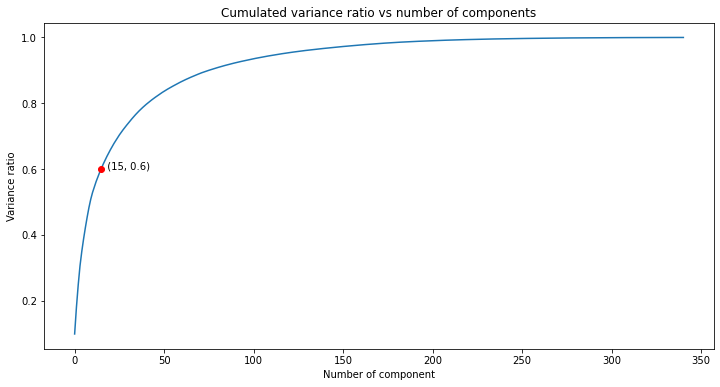

In [65]:
n = nb_genres_USA
scaler = MinMaxScaler()
X_features = scaler.fit_transform(df_genres_one_hot)
pca = PCA(n)
pca.fit(X_features)
pca_variance = pca.explained_variance_
pca_variance_ratio = pca.explained_variance_ratio_

csum = np.cumsum(pca_variance_ratio)
plt.figure(figsize=(12, 6))
plt.plot(csum)
plt.plot(15, 0.6, marker='o', color='red')
plt.ylabel('Variance ratio')
plt.xlabel('Number of component')
plt.title('Cumulated variance ratio vs number of components')
plt.text(15, 0.6, '  ({}, {})'.format(15, 0.6))
plt.show()

In [66]:
n = 15
scaler = StandardScaler()
X_features = scaler.fit_transform(df_genres_one_hot)
pca = PCA(n)
pca.fit_transform(X_features)
pca_variance = pca.explained_variance_

In [67]:
# Number of components
n_pcs = pca.components_.shape[0]

best_four_important = []
most_important_names = []
n_best = 4
initial_feature_names = genres_one_hot_labels
for i in range(n_pcs):
    elts = np.argsort((pca.components_[i]))[::-1][:n_best]
    best_four_important.append(elts)
    most_important_names.append([initial_feature_names[elts[i]] for i in range(n_best)])

In [68]:
new_space = pca.transform(df_genres_one_hot.values)
new_space = new_space.argmax(axis=1)

df_genres_one_hot['m_genre_PCA'] = new_space
df_genres_one_hot['m_genre_PCA'] = df_genres_one_hot['m_genre_PCA'].apply(lambda x: ", ".join(most_important_names[x]))

In [69]:
df_movies_genre_PCA = df_movies_USA.merge(df_genres_one_hot[['m_genre_PCA']], left_on='wikipedia_m_ID',
                                          right_on='wikipedia_m_ID')
df_movies_genre_PCA.head()

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_genre_PCA
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","Thriller, Crime Thriller, Action, Mystery"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],United States of America,"[Mystery, Biographical film, Drama, Crime Drama]","Mystery, Horror, Children's/Family, Drama"
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"[Silent film, English Language]",United States of America,"[Short Film, Silent film, Indie, Black-and-whi...","Detective fiction, Detective, Sword and sorcer..."
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],United States of America,"[Musical, Comedy, Black-and-white]","Detective fiction, Detective, Sword and sorcer..."
4,175026,/m/017n1p,Sarah and Son,1930-01-01,NaN,86.0,[English Language],United States of America,"[Drama, Black-and-white]","Detective fiction, Detective, Sword and sorcer..."


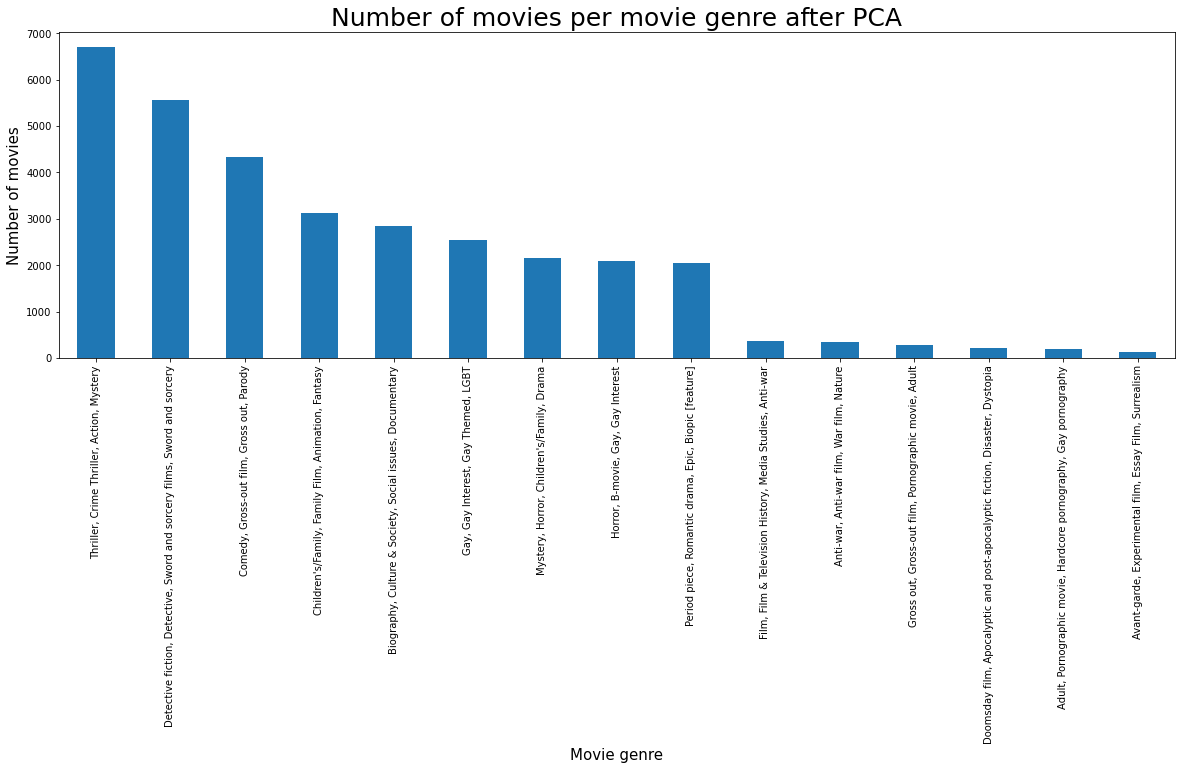

In [70]:
plt.figure(figsize=(20, 6))
df_movies_genre_PCA['m_genre_PCA'].value_counts().plot(kind='bar', figsize=(20, 6))
plt.title('Number of movies per movie genre after PCA', fontsize=25)
plt.xlabel('Movie genre', fontsize=15)
plt.ylabel('Number of movies', fontsize=15)
plt.show()

## 4.5 Merge with characters dataset

In [71]:
df_chars = df_chars.merge(df_movies_genre_PCA[['wikipedia_m_ID', 'm_genre_PCA']], on='wikipedia_m_ID', how='left')

# 5. Score computation
## 5.1 Load the numbers dataset

In [72]:
# CONSTANTS
YEAR_OFFSET = 2  # if 3: last triplet 2019, 2020, 2021;; if 2: last triplet 2020, 2021, 2022
START_INDEX = 28  # 20 correspond to the triplet 2000, 2001, 2002
START_YEAR = 1980 + START_INDEX

In [73]:
# Read the tsv files having the actor's popularity
tab_years = np.arange(1980, 2022 + 1)
actors_rating = []
for i, year in enumerate(tab_years):
    path_numbers = os.path.join(THE_NUMBERS_PATH, 'actors_{}_the_numbers.tsv'.format(year))
    actors_rating.append(pd.read_csv(path_numbers,
                                     sep='\t',
                                     escapechar=',',
                                     names=['actor_name', 'popularity', 'movies', 'avg_billing']))

## 5.2 Creation of a pipeline

#### Check for duplicated actor name for each year

In [74]:
# Check for duplicated actor name for each year
total_duplicated = 0
for i in range(len(tab_years)):
    total_duplicated += actors_rating[i].duplicated(subset='actor_name').sum()
print('There are {} actors that appear twice in the same year.'.format(total_duplicated))

There are 0 actors that appear twice in the same year.


#### Formatting the dataset in a useful way

In [75]:
number_actors_per_year = []
df_ratings_all_years = actors_rating[0].set_index('actor_name')[['popularity']]
df_ratings_all_years.iloc[[78]]
df_ratings_all_years.set_axis([*df_ratings_all_years.columns[:-1], int('{}'.format(1980))], axis=1, inplace=True)
for i in range(len(tab_years) - 1):
    number_actors_per_year.append((len(actors_rating[i + 1])))
    df_ratings_all_years = pd.concat(
        [df_ratings_all_years, actors_rating[i + 1].set_index('actor_name')[['popularity']]], axis=1)
    df_ratings_all_years.set_axis([*df_ratings_all_years.columns[:-1], int('{}'.format(i + 1 + 1980))], axis=1,
                                  inplace=True)
df_ratings_all_yearsT = df_ratings_all_years.T

ACTORS = list(df_ratings_all_yearsT)  # all the actors present in the numbers dataset
df_ratings_all_years

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,440.0,364.0,198.0,99.0,NaN,NaN,63.0,63.0,63.0,NaN,...,NaN,16.0,16.0,16.0,NaN,59.0,59.0,59.0,NaN,NaN
Clint Eastwood,360.0,263.0,260.0,180.0,347.0,343.0,332.0,165.0,155.0,100.0,...,16.0,16.0,NaN,NaN,NaN,71.0,71.0,71.0,36.0,36.0
John Belushi,269.0,295.0,217.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Burt Reynolds,262.0,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goldie Hawn,258.0,170.0,251.0,81.0,147.0,66.0,132.0,125.0,125.0,59.0,...,NaN,NaN,NaN,NaN,43.0,43.0,43.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Myha’la Herrold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0
Chase Sui Wonders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0
Rachel Sennott,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0


#### Mean of the score per actor

In [76]:
df_ratings_all_years['mean_score'] = df_ratings_all_years.mean(axis=1)
print("Actors with the highest mean popularity score computed on the 42 years of the dataset.")
df_ratings_all_years.fillna(0, inplace=True)

Actors with the highest mean popularity score computed on the 42 years of the dataset.


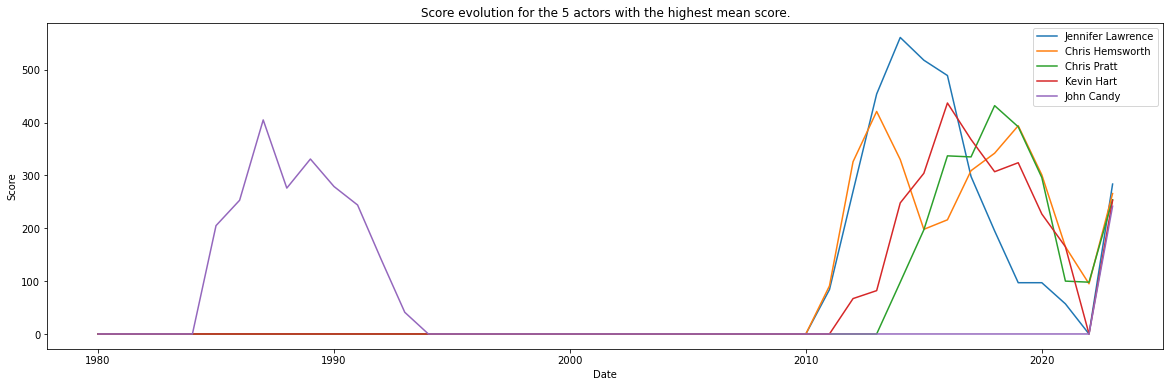

In [77]:
df_ratings_all_years.sort_values(by='mean_score', ascending=False).head().rename_axis(None).T.plot(figsize=(20, 6))
plt.title("Score evolution for the 5 actors with the highest mean score.")
plt.xlabel('Date')
plt.ylabel('Score')
plt.show()

#### Looking at the actor with highest average score

In [78]:
df_ratings_all_years['is_na'] = df_ratings_all_years.apply(lambda row: row.isna().sum().sum(), axis=1)
print("Actors that have the least \"empty years\" throughout the 42 years of the dataset.")
df_ratings_all_years.sort_values(by='is_na', ascending=True).head(3)

Actors that have the least "empty years" throughout the 42 years of the dataset.


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,mean_score,is_na
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,440.0,364.0,198.0,99.0,0.0,0.0,63.0,63.0,63.0,0.0,...,16.0,16.0,0.0,59.0,59.0,59.0,0.0,0.0,109.3125,0
Maude Apatow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0000,0
Iris Apatow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0000,0


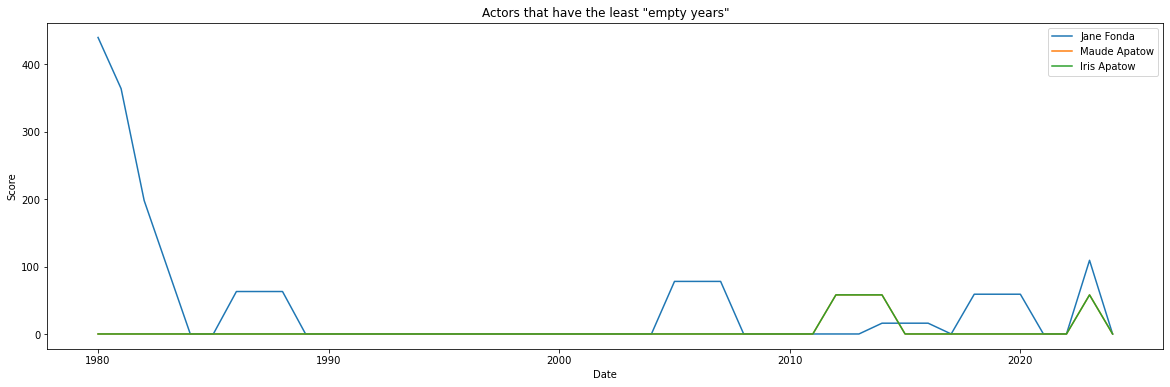

In [79]:
df_ratings_all_years.sort_values(by='is_na', ascending=True).head(3).rename_axis(None).T.plot(figsize=(20, 6))
plt.title("Actors that have the least \"empty years\"")
plt.xlabel('Date')
plt.ylabel('Score')
plt.show()

In [80]:
df_ratings_all_years.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,mean_score,is_na
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,440.0,364.0,198.0,99.0,0.0,0.0,63.0,63.0,63.0,0.0,...,16.0,16.0,0.0,59.0,59.0,59.0,0.0,0.0,109.312500,0
Clint Eastwood,360.0,263.0,260.0,180.0,347.0,343.0,332.0,165.0,155.0,100.0,...,0.0,0.0,0.0,71.0,71.0,71.0,36.0,36.0,132.052632,0
John Belushi,269.0,295.0,217.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.500000,0
Burt Reynolds,262.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.500000,0
Goldie Hawn,258.0,170.0,251.0,81.0,147.0,66.0,132.0,125.0,125.0,59.0,...,0.0,0.0,43.0,43.0,43.0,0.0,0.0,0.0,104.814815,0


## 5.3 Retrieve yearly score of each actor

In [81]:
def find_score_7879(row, year_to_check):
    """
    Find the yearly score of each actor but the score from The Numbers is over the last three years.
    The combined score of year n = yearly score year n + yearly score year n-1 + yearly score year n-2
    That's why the score of year 1979 and 1978 are computed and added to the dataframe.

    :param row: scores of an actor through time, taken from The Numbers, where the score of each year is the cumulative sum of year n, n-1 and n-2.
    :param year_to_check: year we want to retrieve the score, must be 1978 or 1979
    :return: Score of the year 1978 or 1979 depending on year_to_check
    """

    reel_moinsa = 0
    reel_moinsb = 0
    first_zero_found = 0
    cum78 = 0
    cum79 = 0
    for i, year in enumerate(tab_years):
        if first_zero_found == 1:
            break
        if row[year] == 0:
            first_zero_found = 1
            for j in range(1, year - 1979):
                reel_moinsc = row[year - j] - reel_moinsa - reel_moinsb
                reel_moinsa = reel_moinsb

                cum78 = reel_moinsc
                cum79 = cum78 + reel_moinsb

                reel_moinsb = reel_moinsc

    if year_to_check == 1978:
        return cum78
    elif year_to_check == 1979:
        return cum79
    else:
        print("error, wrong date")
        return -1

In [82]:
df_ratings_all_years[1978] = df_ratings_all_years.apply(lambda row: find_score_7879(row, 1978), axis=1)
df_ratings_all_years[1979] = df_ratings_all_years.apply(lambda row: find_score_7879(row, 1979), axis=1)
actor_name_index = df_ratings_all_years.index.values
first_column = df_ratings_all_years.pop(1979)
df_ratings_all_years.insert(0, 1979, first_column)
first_column = df_ratings_all_years.pop(1978)
df_ratings_all_years.insert(0, 1978, first_column)

In [83]:
df_ratings_all_years.reset_index(inplace=True)

In [84]:
# Find the yearly score of each actor

df_yearly_score = df_ratings_all_years.copy()

def find_yearly_score(row):
    """
    Computes score for each specific year.

    :param row: actor's combined scores through time, each score being score of year n + score of year n-1 + score of year n-2
    :return: actor's score per year
    """

    yearly_score = []
    for i, year in enumerate(tab_years):

        if year == 1980:
            yearly_score.append(row[1978])  #1978
            yearly_score.append(row[1979] - yearly_score[i])  #1979
        yearly_score.append(row[year] - yearly_score[i + 1] - yearly_score[i])  # the rest
    return yearly_score


In [85]:
# Errors in the numbers
df_yearly_score.loc[26, 1979] = 58  # Harrison Ford had a wrong value for 1979.
df_yearly_score.loc[6, 1981] = 152  # Alan Alda had a wrong score for 1981
df_yearly_score.loc[6, 1982] = 90  # Alan Alda had a wrong score for 1981
df_yearly_score.loc[6, 1983] = 90  # Alan Alda had a wrong score for 1981

In [86]:
supp_tab_years = tab_years.tolist()
tab_years_descending = tab_years.tolist()
tab_years_descending.reverse()
supp_tab_years.insert(0, 1979)
supp_tab_years.insert(0, 1978)

df_yearly_score = df_yearly_score.apply(lambda row: find_yearly_score(row), axis=1).to_frame()

# Change over the df to have it in a normalized way.
df_reel_years = pd.DataFrame(df_yearly_score[0].to_list(), columns=supp_tab_years)
df_reel_years['actor_name'] = actor_name_index
df_reel_years.set_index('actor_name', inplace=True)

## 5.4 Retrieve year of revelation of each actor

In [87]:
df_numbers_yearly = df_reel_years.copy()

In [88]:
df_numbers_yearly.drop([1978, 1979], inplace=True, axis=1)

In [89]:
columns = df_numbers_yearly.columns

def get_min_year(row):
    """
    Retrieves the first year an actor became famous.

    :param row: scores of an actor for each year, according to The Numbers
    :return: first year this actor had a positive score, aka appeared in The Numbers, aka became famous.
    """

    for x in columns[:-2]:
        if row[x] > 0:
            return x
    return 0

In [90]:
def get_min_year_score(row):
    """
    Retrieves the score of the first year an actor became famous.

    :param row: scores of an actor for each year, according to The Numbers
    :return: score of this actor the first year they became famous.
    """

    for x in columns[:-2]:
        if row[x] > 0:
            return float(row[x])
    return 0

In [91]:
df_numbers_yearly['min_year'] = df_numbers_yearly.apply(lambda row: get_min_year(row), axis=1)
df_numbers_yearly['min_year_score'] = df_numbers_yearly.apply(lambda row: get_min_year_score(row), axis=1)
df_numbers_yearly.head(3)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,min_year,min_year_score
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,99.0,99.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,0.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,1980,99.0
Clint Eastwood,174.0,0.0,86.0,94.0,167.0,82.0,83.0,0.0,72.0,28.0,...,0.0,0.0,0.0,71.0,0.0,0.0,36.0,0.0,1980,174.0
John Belushi,92.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1980,92.0


## 5.5 Filter out actors that are not in the CMU dataset

In [92]:
# Keep only actors that appear in the characters dataset
df_numbers_yearly = df_numbers_yearly.merge(df_chars.drop_duplicates('actor_name', keep='first')[['actor_name']],
                                            on='actor_name')
df_numbers_yearly.shape[0]

2064

## 5.6 Compute fame score

#### Cumulated number of movies per actor per year after revelation

In [93]:
df_chars['m_release_year'] = df_chars['m_release_date'].dt.year

In [94]:
columns = ['actor_name', 'min_year', 'min_year_score']
df_chars = df_chars.merge(df_numbers_yearly.reset_index()[columns], on='actor_name', how='left')

In [95]:
map_nb_movies_per_year = df_chars.groupby(['m_release_year', 'actor_name']).agg(
    {'wikipedia_m_ID': 'count', 'min_year': 'first'}).reset_index()
map_nb_movies_per_year

,m_release_year,actor_name,wikipedia_m_ID,min_year
0,1896,John C. Rice,1,NaN
1,1896,May Irwin,1,NaN
2,1903,Arthur White,1,NaN
3,1903,Broncho Billy Anderson,1,NaN
4,1903,Donald Gallaher,1,NaN
...,...,...,...,...
139022,2012,Zoe Saldana,1,2002.0
139023,2012,Zohren Weiss,1,NaN
139024,2012,Zoë Bell,1,NaN
139025,2012,Óscar Jaenada,1,NaN


In [96]:
nb_years = range(1980, 2013)
list_years = dict()
for y in nb_years:
    filter_conditions = (
            map_nb_movies_per_year['m_release_year'] <= y
    )
    l_year = map_nb_movies_per_year[filter_conditions]
    l_year = l_year.groupby('actor_name')['wikipedia_m_ID'].sum().reset_index()
    l_year['wikipedia_m_ID'] = l_year['wikipedia_m_ID'].astype(int)
    l_year.rename({'wikipedia_m_ID': 'nb_movies_until_{}'.format(y)}, axis=1, inplace=True)
    list_years.update({y: l_year})

In [97]:
nb_years = range(1980, 2013)
list_years_revealed = dict()
for y in nb_years:
    filter_conditions = (
            (map_nb_movies_per_year['m_release_year'] <= y) &
            (map_nb_movies_per_year['min_year'] <= map_nb_movies_per_year['m_release_year'])
    )
    l_year = map_nb_movies_per_year[filter_conditions]
    l_year = l_year.groupby('actor_name')['wikipedia_m_ID'].sum().reset_index()
    l_year['wikipedia_m_ID'] = l_year['wikipedia_m_ID'].astype(int)
    l_year.rename({'wikipedia_m_ID': 'nb_movies_after_revelation_until_{}'.format(y)}, axis=1, inplace=True)
    list_years_revealed.update({y: l_year})

In [98]:
for key, year in list_years.items():
    df_numbers_yearly = df_numbers_yearly.merge(year, on='actor_name', how='left')
    df_numbers_yearly['nb_movies_until_{}'.format(key)] = df_numbers_yearly['nb_movies_until_{}'.format(key)].fillna(
        0).astype(int)

for key, year in list_years_revealed.items():
    df_numbers_yearly = df_numbers_yearly.merge(year, on='actor_name', how='left')
    df_numbers_yearly['nb_movies_after_revelation_until_{}'.format(key)] = df_numbers_yearly[
        'nb_movies_after_revelation_until_{}'.format(key)].fillna(0).astype(int)
df_numbers_yearly.head()

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,nb_movies_after_revelation_until_2003,nb_movies_after_revelation_until_2004,nb_movies_after_revelation_until_2005,nb_movies_after_revelation_until_2006,nb_movies_after_revelation_until_2007,nb_movies_after_revelation_until_2008,nb_movies_after_revelation_until_2009,nb_movies_after_revelation_until_2010,nb_movies_after_revelation_until_2011,nb_movies_after_revelation_until_2012
0,Jane Fonda,99.0,99.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,...,10,10,11,11,12,12,12,12,14,14
1,Clint Eastwood,174.0,0.0,86.0,94.0,167.0,82.0,83.0,0.0,72.0,...,23,24,24,24,25,26,26,26,26,27
2,John Belushi,92.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,3,3,3,3,3,3,3,3,3
3,Burt Reynolds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12,13,17,21,23,25,25,25,26,26
4,Goldie Hawn,170.0,0.0,81.0,0.0,66.0,0.0,66.0,59.0,0.0,...,17,17,17,17,17,17,17,17,17,17


In [99]:
# We don't need scores after 2012
columns_to_drop = [y for y in range(2013, 2023)]
df_numbers_yearly.drop(columns_to_drop, axis=1, inplace=True)

#### Score computation

In [100]:
years = [y for y in range(2012, 1979, -1)]
nb_movies = ['nb_movies_after_revelation_until_{}'.format(y) for y in range(2012, 1979, -1)]

In [101]:
def compute_weight(row):
    """
    Computes weighted scores to use as our metric for the actor's famousness. The score of each year is a cumulative-weighted score. Weights are the number of movies an actor starred in up until the corresponding year, and they scale down with 1 / (distance in years).

    For instance if an actor starred in 2 movies in 1993, and his 1993 score was 34, his 1993 weighted-score is 2*34 = 68. If he starred in one movie in 1994, and his 1994 score is 56, his 1994 weighted-score is 3*56 + 2*34/2 = 202. If he stars in one movie in 1995 and his score this year is 90, his weighted score for 1995 is 4*90 + 3*56/2 + 2*34/3 = 467.

    :param row: an actor's yearly scores
    :return: actor's famousness score per year, computed as described above
    """

    one_year = 0
    actor_score_weighted = []
    list_scores = row[years]
    weights = row[nb_movies]
    for i, year_out in enumerate(list_scores):
        one_year = 0
        for dist, (score, weight) in enumerate(zip(list_scores[i:], weights[i:]), start=1):
            one_year = one_year + score * weight / dist
        actor_score_weighted.append(one_year)
    actor_score_weighted.reverse()
    return actor_score_weighted

In [102]:
%%time
df_yearly_decayed = df_numbers_yearly.apply(lambda row: compute_weight(row), axis=1).copy().to_frame()

CPU times: total: 4.31 s
Wall time: 4.4 s


In [103]:
df_numbers_yearly.set_index('actor_name', inplace=True)
years.reverse()

In [104]:
df_yearly_decayed = pd.DataFrame(df_yearly_decayed[0].to_list(), columns=years).copy()
df_yearly_decayed['actor_name'] = df_numbers_yearly.index.values
df_yearly_decayed.set_index('actor_name', inplace=True)

In [105]:
df_yearly_decayed = df_yearly_decayed.loc[~(df_yearly_decayed == 0).all(axis=1)]

In [106]:
df_yearly_decayed.reset_index(inplace=True)

In [107]:
filter_conditions = (
        (df_yearly_decayed['actor_name'] == 'Burt Reynolds') |
        (df_yearly_decayed['actor_name'] == 'Denzel Washington') |
        (df_yearly_decayed['actor_name'] == 'Meryl Streep') |
        (df_yearly_decayed['actor_name'] == 'Bruce Willis')
)
df_yearly_decayed.loc[filter_conditions]

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
3,Burt Reynolds,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,...,14.857143,13.000000,2799.555556,1404.400000,938.787879,705.666667,565.600000,472.095238,405.219048,355.000000
18,Meryl Streep,0.0,0.0,148.0,320.0,284.333333,751.0,864.433333,517.866667,377.87619,...,1168.239338,926.633319,788.376528,3382.726084,1969.270508,5418.813094,8914.494664,5214.388815,3807.210202,5433.933031
338,Bruce Willis,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,75.000000,319.50000,...,6837.117523,5275.770486,8609.241538,6663.609501,10071.305226,6811.595987,6950.876427,11341.698926,7555.336701,12138.982689
414,Denzel Washington,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,...,4101.144811,6480.237531,4207.311607,7413.886729,7901.676182,5289.325816,5804.717693,8748.336365,5788.651092,9897.153187


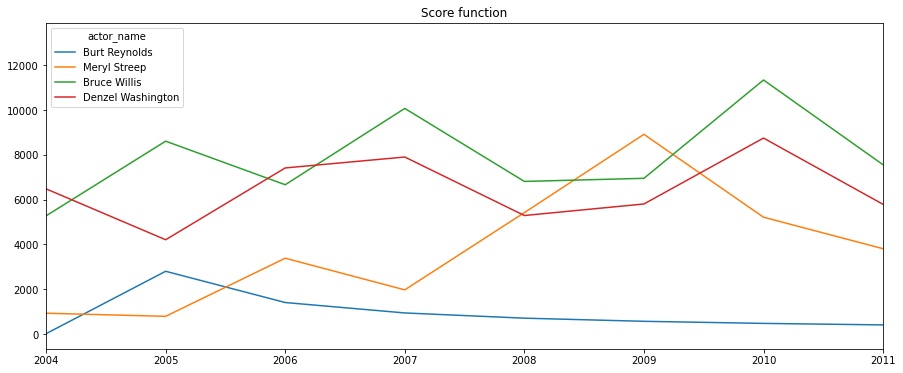

In [108]:
a = df_yearly_decayed.loc[filter_conditions].T
a.columns = a.iloc[0]

a = a.iloc[1:, :]
a.plot(figsize=(15, 6))
plt.xlim(2004, 2011)
plt.title("Score function")
plt.show()

In [109]:
nb_new_actors = dict()
for y in df_yearly_decayed.columns[1:]:
    nb = (df_yearly_decayed[y] == 0).sum()
    nb_new_actors.update({y: nb})

<BarContainer object of 33 artists>

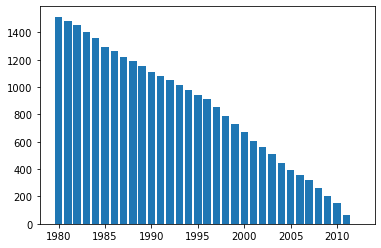

In [110]:
plt.bar(nb_new_actors.keys(), nb_new_actors.values())

#### Retrieve year of revelation

In [111]:
df_yearly_decayed = df_yearly_decayed.copy()
columns = df_yearly_decayed.columns[1:]
df_yearly_decayed['min_year'] = df_yearly_decayed.apply(lambda row: get_min_year(row), axis=1)
df_yearly_decayed['min_year_score'] = df_yearly_decayed.apply(lambda row: get_min_year_score(row), axis=1)
df_yearly_decayed.head(3)

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2005,2006,2007,2008,2009,2010,2011,2012,min_year,min_year_score
0,Jane Fonda,99.0,346.5,181.500000,123.75,94.050000,75.900000,441.642857,243.803571,174.125000,...,892.587692,462.089744,317.717532,244.955719,200.891379,171.213548,149.784285,133.531250,1980,99.0
1,Clint Eastwood,348.0,174.0,460.000000,729.00,1755.266667,1706.666667,1880.347619,1189.833333,1686.509524,...,2139.009068,1715.610398,1470.104342,3616.394846,2334.278040,1850.068876,1576.740235,1825.545952,1980,348.0
2,John Belushi,92.0,421.0,218.166667,148.00,112.150000,90.333333,75.642857,65.071429,57.097222,...,18.538462,17.830484,17.174603,16.565271,15.997701,15.467742,14.971774,14.506629,1980,92.0


# 6. Output as clean CSV

In [119]:
OUTPUT_DATA_PATH = './preprocessed_data'

In [120]:
OUTPUT_FILE = 'characters_preprocessed.tsv'
OUTPUT_PATH = os.path.join(OUTPUT_DATA_PATH, OUTPUT_FILE)
df_chars.to_csv(OUTPUT_PATH, sep="\t", index=False)

In [121]:
OUTPUT_FILE = 'american_movies_preprocessed.tsv'
OUTPUT_PATH = os.path.join(OUTPUT_DATA_PATH, OUTPUT_FILE)
df_movies_genre_PCA.to_csv(OUTPUT_PATH, sep="\t", index=False)

In [122]:
OUTPUT_FILE_NUMBERS = 'score_function.tsv'
OUTPUT_PATH = os.path.join(OUTPUT_DATA_PATH, OUTPUT_FILE_NUMBERS)
df_yearly_decayed.to_csv(OUTPUT_PATH, sep="\t", index=False)